In [1]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
import corner
import tensorflow as tf
import tensorflow_addons as tfa
import tensorflow_probability as tfp

tfd = tfp.distributions
tfb = tfp.bijectors

2022-07-06 08:39:31.966678: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-06 08:39:31.966703: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
n_samples = 1000

data = np.random.uniform(size=[n_samples, 1])

In [3]:
def define_nf():
    
    return tfd.TransformedDistribution(
        distribution=tfd.Sample(tfd.Normal(loc=0., scale=1.), sample_shape=[1]),
        bijector=tfb.MaskedAutoregressiveFlow(tfb.AutoregressiveNetwork(
            params=2,
            hidden_units=[4],
            activation='relu',
            )),
        )

In [4]:
nf = define_nf()

2022-07-06 08:39:33.662803: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-07-06 08:39:33.662827: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-07-06 08:39:33.662839: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (phy-190401): /proc/driver/nvidia/version does not exist
2022-07-06 08:39:33.663074: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
def define_model(nf):
    
    x = tf.keras.Input(shape=[1], dtype=tf.float32)

    return tf.keras.Model(inputs=x, outputs=nf.log_prob(x))

In [6]:
model = define_model(nf)
model.compile(
    optimizer=tf.optimizers.Adam(),
    loss=lambda _, log_prob: -log_prob,
    )

In [7]:
nf.variables, model.weights

((<tf.Variable 'dense_1/kernel:0' shape=(4, 2) dtype=float32, numpy=
  array([[ 0.36922455,  0.7164767 ],
         [-0.8297026 ,  0.8631344 ],
         [-0.607779  ,  0.05939698],
         [ 0.86367106, -0.37666106]], dtype=float32)>,
  <tf.Variable 'dense_1/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>,
  <tf.Variable 'dense/kernel:0' shape=(1, 4) dtype=float32, numpy=array([[ 0., -0., -0.,  0.]], dtype=float32)>,
  <tf.Variable 'dense/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>),
 [<tf.Variable 'dense/kernel:0' shape=(1, 4) dtype=float32, numpy=array([[ 0., -0., -0.,  0.]], dtype=float32)>,
  <tf.Variable 'dense/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>,
  <tf.Variable 'dense_1/kernel:0' shape=(4, 2) dtype=float32, numpy=
  array([[ 0.36922455,  0.7164767 ],
         [-0.8297026 ,  0.8631344 ],
         [-0.607779  ,  0.05939698],
         [ 0.86367106, -0.37666106]], dtype=float32)>,


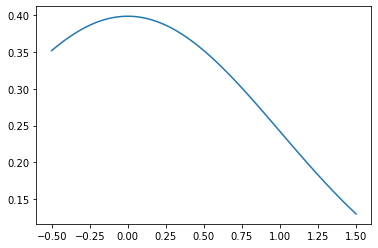

In [8]:
xx = np.linspace(-.5, 1.5, 100)
px = np.exp(nf.log_prob(xx[:, None]))
plt.plot(xx, px);

In [9]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./saving.hdf5',
        monitor='loss',
        mode='min',
        save_weights_only=True,
        save_best_only=True,
        save_freq='epoch',
        verbose=1,
        ),
    ]

result = model.fit(
    x=data, y=np.zeros(n_samples), epochs=10, callbacks=callbacks,
    )

Epoch 1/10
 1/32 [..............................] - ETA: 25s - loss: 1.1039
Epoch 1: loss improved from inf to 1.06777, saving model to ./saving.hdf5
32/32 [==============================] - 1s 2ms/step - loss: 1.0678
Epoch 2/10
24/32 [=====================>........] - ETA: 0s - loss: 1.0342
Epoch 2: loss improved from 1.06777 to 1.03016, saving model to ./saving.hdf5
32/32 [==============================] - 0s 3ms/step - loss: 1.0302
Epoch 3/10
28/32 [=========================>....] - ETA: 0s - loss: 0.9958
Epoch 3: loss improved from 1.03016 to 0.99211, saving model to ./saving.hdf5
32/32 [==============================] - 0s 3ms/step - loss: 0.9921
Epoch 4/10
21/32 [==================>...........] - ETA: 0s - loss: 0.9585
Epoch 4: loss improved from 0.99211 to 0.95380, saving model to ./saving.hdf5
32/32 [==============================] - 0s 3ms/step - loss: 0.9538
Epoch 5/10
22/32 [===================>..........] - ETA: 0s - loss: 0.9207
Epoch 5: loss improved from 0.95380 to 0.915

In [10]:
nf.variables, model.weights

((<tf.Variable 'dense_1/kernel:0' shape=(4, 2) dtype=float32, numpy=
  array([[ 0.36922455,  0.7164767 ],
         [-0.8297026 ,  0.8631344 ],
         [-0.607779  ,  0.05939698],
         [ 0.86367106, -0.37666106]], dtype=float32)>,
  <tf.Variable 'dense_1/bias:0' shape=(2,) dtype=float32, numpy=array([ 0.30416417, -0.32889363], dtype=float32)>,
  <tf.Variable 'dense/kernel:0' shape=(1, 4) dtype=float32, numpy=array([[0., 0., 0., 0.]], dtype=float32)>,
  <tf.Variable 'dense/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>),
 [<tf.Variable 'dense/kernel:0' shape=(1, 4) dtype=float32, numpy=array([[0., 0., 0., 0.]], dtype=float32)>,
  <tf.Variable 'dense/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>,
  <tf.Variable 'dense_1/kernel:0' shape=(4, 2) dtype=float32, numpy=
  array([[ 0.36922455,  0.7164767 ],
         [-0.8297026 ,  0.8631344 ],
         [-0.607779  ,  0.05939698],
         [ 0.86367106, -0.37666106]], dtype=f

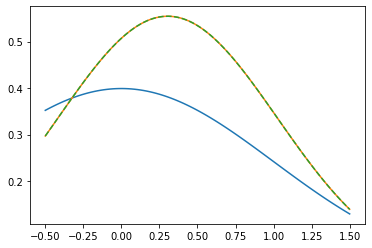

In [11]:
plt.plot(xx, px)

px = np.exp(nf.log_prob(xx[:, None]))
plt.plot(xx, px)

px_ = np.exp(model.predict_on_batch(xx))
plt.plot(xx, px_, ls='--');

In [12]:
with h5py.File('./saving.hdf5', 'r') as h:
    print(h.keys())

<KeysViewHDF5 ['autoregressive_network', 'input_1', 'tf.__operators__.add', 'tf.__operators__.add_1', 'tf.broadcast_dynamic_shape', 'tf.broadcast_to', 'tf.cast', 'tf.compat.v1.pad', 'tf.compat.v1.shape', 'tf.compat.v1.shape_1', 'tf.compat.v1.shape_3', 'tf.compat.v1.shape_4', 'tf.compat.v1.transpose', 'tf.convert_to_tensor', 'tf.convert_to_tensor_1', 'tf.convert_to_tensor_10', 'tf.convert_to_tensor_2', 'tf.convert_to_tensor_3', 'tf.convert_to_tensor_5', 'tf.convert_to_tensor_6', 'tf.convert_to_tensor_7', 'tf.convert_to_tensor_8', 'tf.convert_to_tensor_9', 'tf.identity', 'tf.identity_2', 'tf.math.exp', 'tf.math.multiply', 'tf.math.multiply_1', 'tf.math.multiply_3', 'tf.math.multiply_4', 'tf.math.multiply_5', 'tf.math.negative', 'tf.math.negative_2', 'tf.math.negative_3', 'tf.math.reduce_sum', 'tf.math.reduce_sum_1', 'tf.math.reduce_sum_2', 'tf.math.reduce_sum_3', 'tf.math.squared_difference', 'tf.math.subtract', 'tf.math.subtract_1', 'tf.math.subtract_2', 'tf.math.subtract_3', 'tf.math.t

In [13]:
nf = define_nf()
model = define_model(nf)
nf.variables, model.weights

((<tf.Variable 'dense_1/kernel:0' shape=(4, 2) dtype=float32, numpy=
  array([[ 0.36868167, -0.95214295],
         [ 0.97661686, -0.7839234 ],
         [ 0.24784422, -0.31023717],
         [ 0.40943217, -0.1563251 ]], dtype=float32)>,
  <tf.Variable 'dense_1/bias:0' shape=(2,) dtype=float32, numpy=array([0., 0.], dtype=float32)>,
  <tf.Variable 'dense/kernel:0' shape=(1, 4) dtype=float32, numpy=array([[-0.,  0., -0.,  0.]], dtype=float32)>,
  <tf.Variable 'dense/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>),
 [<tf.Variable 'dense/kernel:0' shape=(1, 4) dtype=float32, numpy=array([[-0.,  0., -0.,  0.]], dtype=float32)>,
  <tf.Variable 'dense/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>,
  <tf.Variable 'dense_1/kernel:0' shape=(4, 2) dtype=float32, numpy=
  array([[ 0.36868167, -0.95214295],
         [ 0.97661686, -0.7839234 ],
         [ 0.24784422, -0.31023717],
         [ 0.40943217, -0.1563251 ]], dtype=float32)>,


In [14]:
model.load_weights('./saving.hdf5')
nf.variables, model.weights

((<tf.Variable 'dense_1/kernel:0' shape=(4, 2) dtype=float32, numpy=
  array([[ 0.36922455,  0.7164767 ],
         [-0.8297026 ,  0.8631344 ],
         [-0.607779  ,  0.05939698],
         [ 0.86367106, -0.37666106]], dtype=float32)>,
  <tf.Variable 'dense_1/bias:0' shape=(2,) dtype=float32, numpy=array([ 0.30416417, -0.32889363], dtype=float32)>,
  <tf.Variable 'dense/kernel:0' shape=(1, 4) dtype=float32, numpy=array([[0., 0., 0., 0.]], dtype=float32)>,
  <tf.Variable 'dense/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>),
 [<tf.Variable 'dense/kernel:0' shape=(1, 4) dtype=float32, numpy=array([[0., 0., 0., 0.]], dtype=float32)>,
  <tf.Variable 'dense/bias:0' shape=(4,) dtype=float32, numpy=array([0., 0., 0., 0.], dtype=float32)>,
  <tf.Variable 'dense_1/kernel:0' shape=(4, 2) dtype=float32, numpy=
  array([[ 0.36922455,  0.7164767 ],
         [-0.8297026 ,  0.8631344 ],
         [-0.607779  ,  0.05939698],
         [ 0.86367106, -0.37666106]], dtype=f

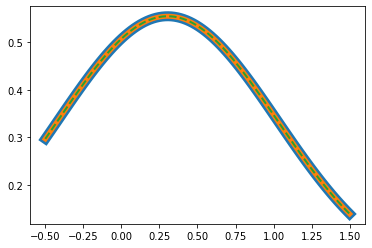

In [15]:
plt.plot(xx, px, lw=10)

px = np.exp(nf.log_prob(xx[:, None]))
plt.plot(xx, px, lw=5)

px_ = np.exp(model.predict_on_batch(xx))
plt.plot(xx, px_, ls='--', lw=2);